2025-07-08 06:04:46.915687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751954687.240802      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751954687.342702      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1751954706.494751      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751954706.495523      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:


--- Train:Test = 10:90 ---
Epoch 1/20, Loss: 5.5693
Epoch 2/20, Loss: 7.0124
Epoch 3/20, Loss: 6.5463
Epoch 4/20, Loss: 5.6337
Epoch 5/20, Loss: 5.9140
Epoch 6/20, Loss: 5.6100
Epoch 7/20, Loss: 5.2662
Epoch 8/20, Loss: 6.2296
Epoch 9/20, Loss: 4.9497
Epoch 10/20, Loss: 5.0211
Epoch 11/20, Loss: 4.5867
Epoch 12/20, Loss: 4.9798
Epoch 13/20, Loss: 4.8816
Epoch 14/20, Loss: 4.9411
Epoch 15/20, Loss: 4.2374
Epoch 16/20, Loss: 4.5632
Epoch 17/20, Loss: 4.3631
Epoch 18/20, Loss: 4.7195
Epoch 19/20, Loss: 4.4685
Epoch 20/20, Loss: 3.7687
Epoch 1/10


I0000 00:00:1751954890.526556     102 service.cc:148] XLA service 0x7fabd4026030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751954890.527899     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751954890.527920     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751954891.180736     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


 41/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6035 - loss: 0.7609

I0000 00:00:1751954894.491092     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.6593 - loss: 0.6849 - val_accuracy: 0.8351 - val_loss: 0.5801
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7969 - loss: 0.4679 - val_accuracy: 0.8580 - val_loss: 0.4742
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8235 - loss: 0.3976 - val_accuracy: 0.8682 - val_loss: 0.3811
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8394 - loss: 0.3652 - val_accuracy: 0.8751 - val_loss: 0.3158
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8517 - loss: 0.3386 - val_accuracy: 0.8788 - val_loss: 0.2844
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8630 - loss: 0.3104 - val_accuracy: 0.8819 - val_loss: 0.2699
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8616 - loss: 0.3047 - val_accuracy: 0.8834 - val_loss: 0.2613
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8635 - loss: 0.2967 - val_accuracy: 0.88

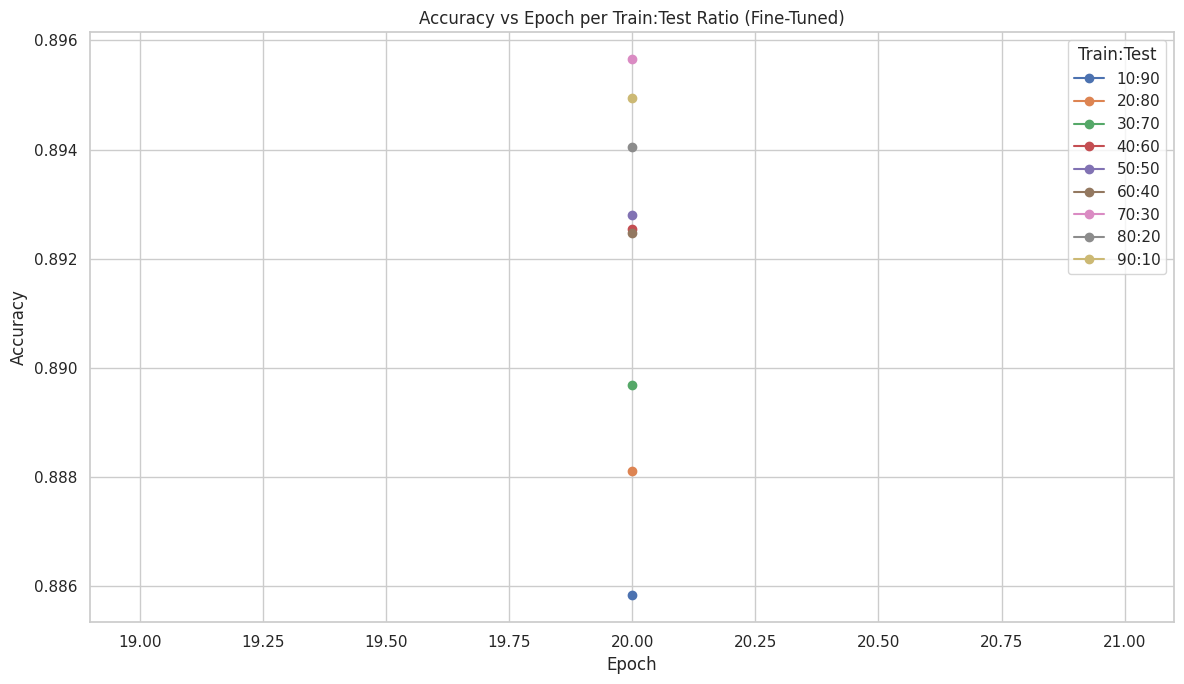

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')
cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]
X = df.drop('label', axis=1)
y = df['label']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Enhanced MoCo encoder with deeper layers, BatchNorm, Dropout
def build_encoderT(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    projection = layers.Dense(32)(x)
    prediction = layers.Dense(32)(layers.Activation('swish')(projection))
    return models.Model(inputs, prediction)

# Contrastive loss
def contrastive_loss(query, key, queue, temperature=0.07):
    query = tf.math.l2_normalize(query, axis=1)
    key = tf.math.l2_normalize(key, axis=1)
    queue = tf.math.l2_normalize(queue, axis=1)
    l_pos = tf.reshape(tf.reduce_sum(query * key, axis=1), [-1,1])
    l_neg = tf.matmul(query, queue, transpose_b=True)
    logits = tf.concat([l_pos, l_neg], axis=1) / temperature
    labels = tf.zeros(logits.shape[0], dtype=tf.int32)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits)
    return tf.reduce_mean(loss)

# Augmentations
def augment_batch(X):
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise

# FIFO queue update
def update_queue(queue, new_keys):
    batch_size = tf.shape(new_keys)[0]
    remaining = queue.shape[0] - batch_size
    new_queue = tf.concat([new_keys, queue[:remaining]], axis=0)
    return tf.stop_gradient(new_queue)

# Momentum encoder update
@tf.function
def momentum_update(query_encoder, key_encoder, m=0.999):
    for q_var, k_var in zip(query_encoder.trainable_variables, key_encoder.trainable_variables):
        k_var.assign(m * k_var + (1 - m) * q_var)

# Training setup
embedding_dim = 32
queue_size = 65536
queue = tf.Variable(tf.math.l2_normalize(tf.random.normal([queue_size, embedding_dim]), axis=1), trainable=False)

ratios = [(10,90), (20,80), (30,70), (40,60), (50,50), (60,40), (70,30), (80,20), (90,10)]
all_results = []

for train_pct, test_pct in ratios:
    print(f"\n--- Train:Test = {train_pct}:{test_pct} ---")
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(np.float32), y.values,
        test_size=test_pct/100,
        stratify=y,
        random_state=42
    )

    query_encoder = build_encoderT(X_train.shape[1])
    key_encoder = build_encoderT(X_train.shape[1])
    for q_var, k_var in zip(query_encoder.variables, key_encoder.variables):
        k_var.assign(q_var)

    optimizer = tf.keras.optimizers.Adam(3e-4)
    batch_size = 512
    epochs = 20
    num_samples = X_train.shape[0]

    for epoch in range(epochs):
        idx = np.random.permutation(num_samples)
        X_shuffled = X_train[idx]

        for i in range(0, num_samples, batch_size):
            batch = X_shuffled[i:i+batch_size]
            if batch.shape[0] < 2:
                continue
            x_q = augment_batch(batch)
            x_k = augment_batch(batch)
            with tf.GradientTape() as tape:
                z_q = query_encoder(x_q, training=True)
                z_k = tf.stop_gradient(key_encoder(x_k, training=True))
                loss = contrastive_loss(z_q, z_k, queue)
            grads = tape.gradient(loss, query_encoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, query_encoder.trainable_variables))
            momentum_update(query_encoder, key_encoder)
            queue.assign(update_queue(queue, z_k))

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.numpy():.4f}")

    # Fine-tuning phase
    query_encoder.trainable = True
    finetune_model = tf.keras.Sequential([
        query_encoder,
        layers.Dense(64, activation='swish'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    finetune_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    finetune_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=256)
    loss, acc = finetune_model.evaluate(X_test, y_test)
    print(f"Fine-tuned Accuracy: {acc:.4f}")

    y_pred = (finetune_model.predict(X_test) > 0.5).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)

    all_results.append({
        'train_pct': train_pct,
        'test_pct': test_pct,
        'epoch': epoch + 1,
        'loss': float(loss),
        'accuracy': acc,
        'f1_class_0': report['0']['f1-score'],
        'f1_class_1': report['1']['f1-score']
    })

results_df = pd.DataFrame(all_results)
results_df.to_csv('moco_finetune_results.csv', index=False)
print("\nSaved results to 'moco_finetune_results.csv'")

# Visualization
sns.set(style="whitegrid")
ratios_unique = results_df[['train_pct', 'test_pct']].drop_duplicates()
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[(results_df['train_pct'] == row['train_pct']) & 
                        (results_df['test_pct'] == row['test_pct'])]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['accuracy'], marker='o', label=label)
plt.title("Accuracy vs Epoch per Train:Test Ratio (Fine-Tuned)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()